This notebook has regression models to predict amount given the timestamp.

The data is based on an hourly basis (for accuracy issues)

# Deposit

Import libraries

In [22]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

Get the dataset

In [23]:
deposit_raw = pd.read_csv("deposit2019.csv")
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")

Retrieve columns and rename columns

In [24]:
deposit = deposit_raw[["systemtranstime","transamount"]]

deposit= deposit.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Convert time to datetime

In [25]:
deposit['time']=pd.to_datetime(deposit.time)


Normalization function and pickle it to file for later use

In [26]:
from sklearn.externals import joblib 
def normalize(z):
    x = z
    x = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(np.vstack(x))
    joblib.dump(min_max_scaler, '/home/sylvia/pawa_project/anomaly_detection_app/services/minmaxscaler.pkl')
    x_scaled = min_max_scaler.transform(np.vstack(x))
    return x_scaled

Get amount hourly

In [27]:
deposit_hour = deposit.resample('60min', on='time').sum()



In [28]:
#deposit_hour = deposit

Normalize amount

In [29]:
deposit_hour['amount']=normalize(deposit_hour['amount'])


Get the train and test dataset
train: is the first 2 months
test: is the third month

In [30]:
train = deposit_hour[deposit_hour.index.month<3]
test = deposit_hour[deposit_hour.index.month==3]

### Classification Trees

Breakdown timestamp to other features so as to pass it to regressors i.e hour,day and day of the week

In [31]:
deposit_hour['hour'] = deposit_hour.index.hour
deposit_hour['week'] =  deposit_hour.index.week
deposit_hour['month'] =  deposit_hour.index.month
deposit_hour['day_of_week'] =  deposit_hour.index.dayofweek

deposit_hour.head()

,amount,hour,week,month,day_of_week
time,,,,,
2018-12-31 21:00:00,0.024803,21,1,12,0
2018-12-31 22:00:00,0.031074,22,1,12,0
2018-12-31 23:00:00,0.070655,23,1,12,0
2019-01-01 00:00:00,0.000000,0,1,1,1
2019-01-01 01:00:00,0.002882,1,1,1,1


Create a train and test dataset of the decomposed timestamp dataframe

In [32]:
train_decompose = deposit_hour[deposit_hour.index.month<3]
test_decompose = deposit_hour[deposit_hour.index.month==3]

Create train and test matrices without y column to pass to regression models

In [33]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

Import libraries for the model

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
 
#these are the hyperparameters that yielded the best test results (no grid search)
clf = RandomForestRegressor(max_depth=7, random_state=15,n_estimators=22)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)

#get r_score
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.6113100119500923 			 0.4877672549365212


Creating dataframe to plot predictions and actual with ease

In [35]:
#using test
predictions= test
predictions['predictions'] = y_

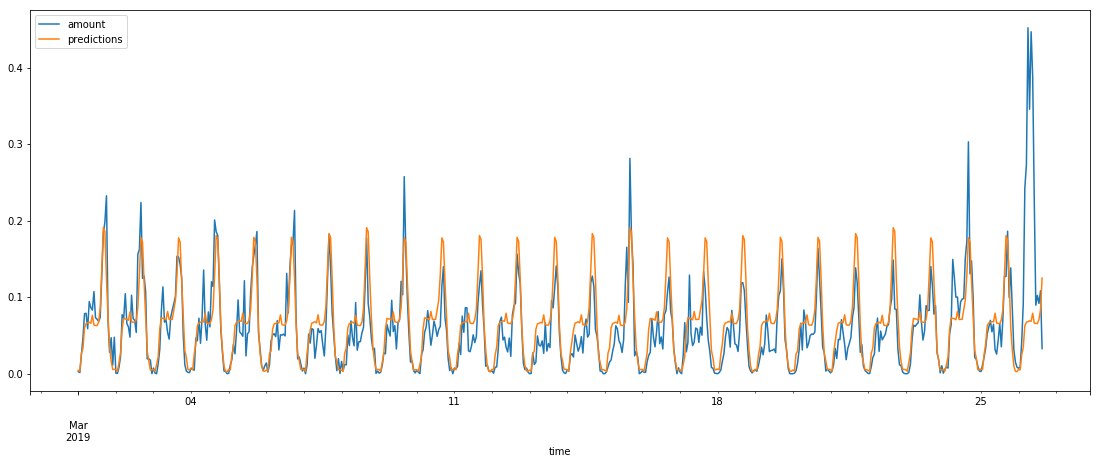

In [36]:
plt.rcParams['figure.figsize']=[19,7]
predictions.plot()

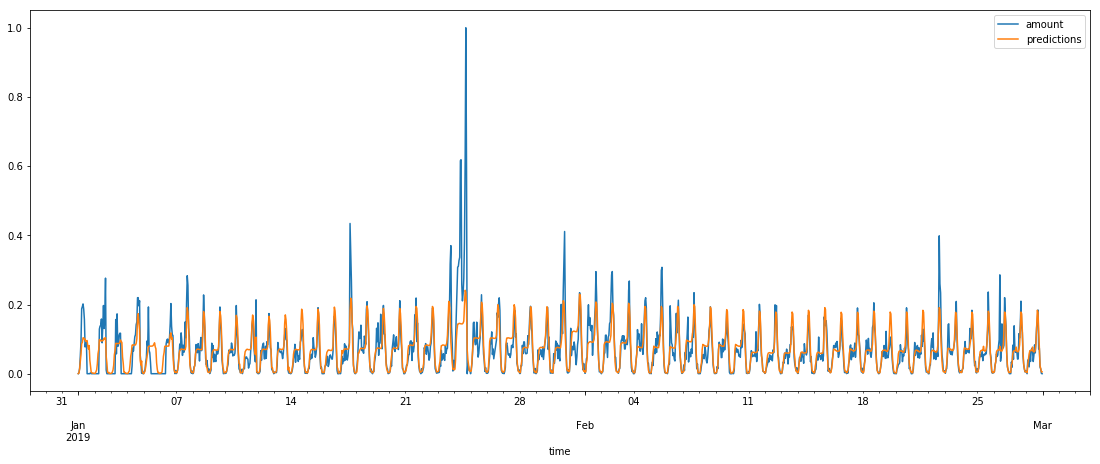

In [37]:
#using train
pred= train
pred['predictions'] = y_pred
pred.plot()

## KNN Regressor


In [38]:
from sklearn.neighbors import KNeighborsRegressor

#number of neighbours with best results (no grid search)
neigh = KNeighborsRegressor(n_neighbors=50)
neigh.fit(X_train, y_train) 
    
y_ = neigh.predict(X_test)
y_pred = neigh.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.5262923800042572 			 0.4621898311033654


## Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

#no tuning of hyperparameters
reg = LinearRegression().fit(X_train, y_train)
y_ = reg.predict(X_test)
y_pred = reg.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.025812787587478514 			 0.016809915996059188


## Stack Regressor

In [40]:
#Ensemble(stacking) for regressors (not sure how it works)
from mlxtend.regressor import StackingRegressor

#use the three algorithms
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=7, random_state=12,n_estimators=21)

neigh = KNeighborsRegressor(n_neighbors=32)
stregr = StackingRegressor(regressors=[rfr, lr, neigh], 
                           meta_regressor=neigh)

# Training the stacking classifier

stregr.fit(X_train, y_train) 

y_ = stregr.predict(X_test)
y_pred = stregr.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))


0.6534176609139761 			 0.4674881667099924


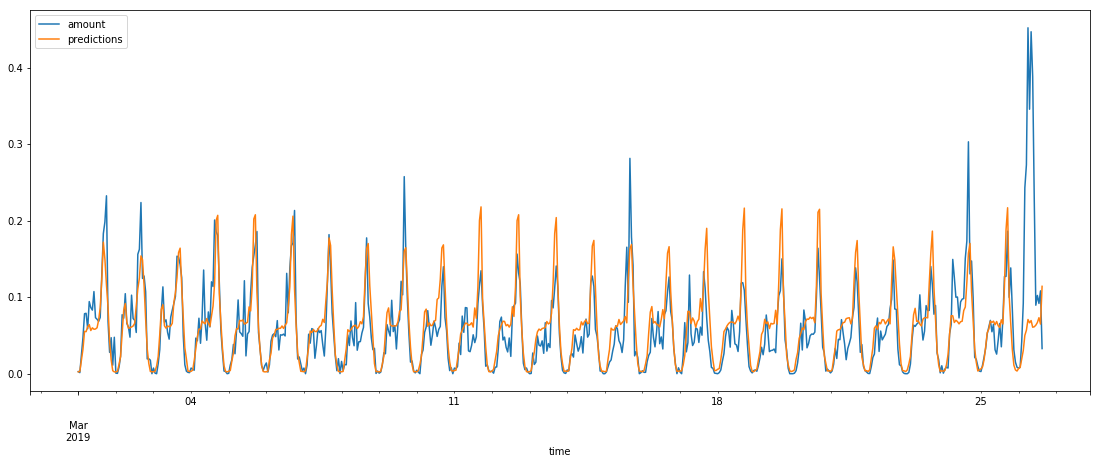

In [41]:
#using test
predictions= test
predictions['predictions'] = y_
predictions.plot()

In [42]:
joblib.dump(stregr, '/home/sylvia/pawa_project/anomaly_detection_app/services/project_deposit_stackregressor.pkl')

['/home/sylvia/pawa_project/anomaly_detection_app/services/project_deposit_stackregressor.pkl']